### *Disclaimer*

This part was included into my proposal.

First of all I would like to thank everyone who participated in creation of Cholec80 dataset and its variations such as the tiny-tools dataset. These works are cited on the github page.
Secondly, I would like to thank Deepak Alapatt and Pietro Mascagni, Vinkle Srivastav and Nicolas Padoy for their tutorial on the use of AI in Surgical Practice. 



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
DATA_URL = (
    'https://s3.unistra.fr/camma_public/github/ai4surgery/cholec-tinytools.zip'
)
path = tf.keras.utils.get_file('cholec-tinytools.zip', DATA_URL, extract=True)
path = path.strip('.zip')                

41648128/41633689 [==============================] - 4s 0us/step


## Data preparation

In this work I will use [Cholec-tinytools](https://s3.unistra.fr/camma_public/github/ai4surgery/cholec-tinytools.zip) dataset, which is based on the Cholec80 dataset, collected and distrivuted by CAMMA. 

The data collection is retrieved from the tutorial by [Deepak Alapatt](https://github.com/DpkApt) and the CAMMA-public group.

This data is to be used for training a model for surgery tools classification in VR. More about the application in the further sections.

In [2]:
# Retrieved from https://github.com/CAMMA-public/ai4surgery             
CLASS_NAMES = ['grasper', 'hook', 'scissor', 'clipper']
NUMBER_CLASSES = 4                   
IMAGE_SIZE = (224, 224)                        
CHANNELS = 3
BATCH_SIZE = 16                                              

train_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=90 
)
train_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/train',
    image_data_generator=train_preprocessing,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    classes=CLASS_NAMES,
    shuffle=True,
)
validation_test_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
validation_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/validation',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

test_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/test',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)


Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.


Example of images used for training and validation

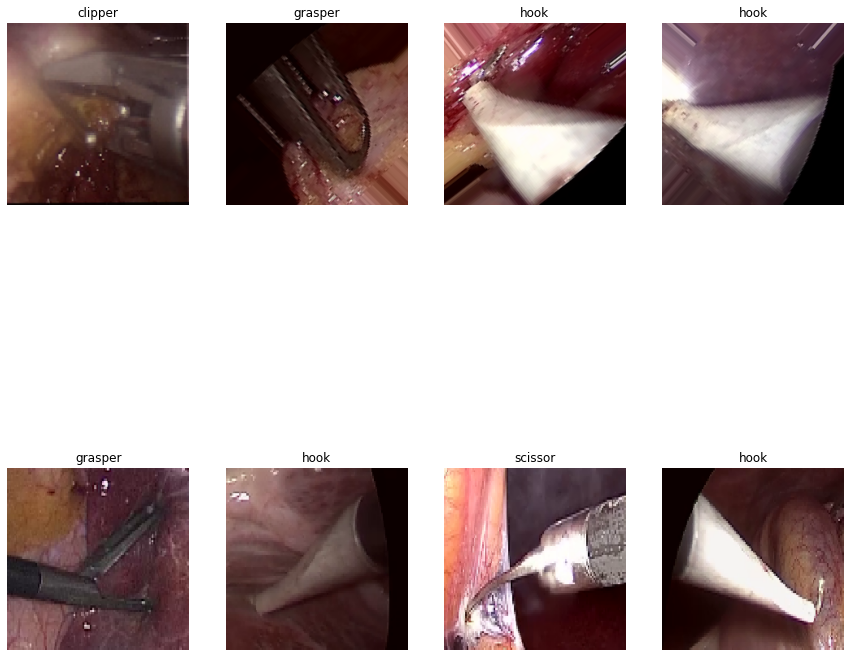

In [3]:
fig, axes = plt.subplots(2,4, figsize=(15, 15))               
random_batch =  random.randint(0, len(train_set)-1)
random_images, random_labels = train_set[random_batch]

for image_number, axs in enumerate(axes[0]):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])
# the same, but for the test set
random_batch =  random.randint(0, len(test_set)-1)
random_images, random_labels = test_set[random_batch]

for image_number, axs in enumerate(axes[1]):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])


## Model training

I will use a very simple, but robust model: InceptyionV3. It is simple enough not to overfit on the given dataset.


In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3


base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUMBER_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 

checkpoint_filepath = '/content/sample_data/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True
  )

model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(), 
                                                             tf.keras.metrics.Precision(), 
                                                             tf.keras.metrics.Recall()]
)

history = model.fit(train_set, validation_data=validation_set, epochs=10,
                    callbacks=[model_checkpoint_callback])

87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/10
75/75 [==============================] - 42s 275ms/step - loss: 0.5291 - auc: 0.9536 - precision: 0.8813 - recall: 0.7175 - val_loss: 0.5274 - val_auc: 0.9647 - val_precision: 0.8308 - val_recall: 0.8100
Epoch 2/10
75/75 [==============================] - 18s 240ms/step - loss: 0.2499 - auc: 0.9873 - precision: 0.9290 - recall: 0.9050 - val_loss: 0.2434 - val_auc: 0.9877 - val_precision: 0.9391 - val_recall: 0.9250
Epoch 3/10
75/75 [==============================] - 19s 248ms/step - loss: 0.1267 - auc: 0.9971 - precision: 0.9635 - recall: 0.9458 - val_loss: 0.2279 - val_auc: 0.9893 - val_precision: 0.9545 - val_recall: 0.9450
Epoch 4/10
75/75 [==============================] - 17s 227ms/step - loss: 0.1527 - auc: 0.9955 - precision: 0.9560 - recall: 0.9408 - val_loss: 0.2264 - val_auc: 0.9883 - val_precision: 0.9391 - val_recall: 0.9250
Epoch 5/10
75/75 [==============================] - 18s 240ms/step - loss: 

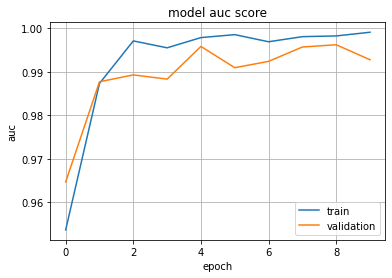

In [7]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

In [6]:
l, a, p, r = model.evaluate(test_set)
print(f"Resulting model has {l} loss, {a} auc score and {p}/{r}\
 precision/recall on the test set")

38/38 [==============================] - 3s 67ms/step - loss: 0.1291 - auc: 0.9946 - precision: 0.9715 - recall: 0.9683
Resulting model has 0.12913240492343903 loss, 0.9946237802505493 auc score and 0.9715242981910706/0.9682804942131042 precision/recall on the test set


Resulting model has high precision, recall and auc scores

## Inference for VR environment

Actually, there are two ways for using Deep models in VR environment (given we have no VR images). 
1. Train the model on synthetic data.
2. Preprocess VR images so that they are similar to the ordinary images

Issue with the first method: it is not flexible. If we change the VR equipment, the distrortion could change as well. So the model should be retrained. 

Issue with the second method: such preprocessing could change the data domain, so we have to make sure that everything is OK.


**UPD**: in the further work method 1 is used, method 2 is not suitable for the required task

In [8]:
import cv2

### 1-st method

Generating distortion to make images similar to VR images

In [12]:
import scipy
import numpy as np


def preprocess(im):
    k_1 = 0.25
    k_2 = 0.1

    h,w,_ = im.shape

    x,y = np.meshgrid(np.float32(np.arange(w)),np.float32(np.arange(h)))
    x_c = w/2 
    y_c = h/2 
    x = x - x_c
    y = y - y_c
    x = x/x_c
    y = y/y_c

    radius = np.sqrt(x**2 + y**2) 

    m_r = 1 + k_1*radius + k_2*radius**2 

    x= x * m_r 
    y = y * m_r

    x= x*x_c + x_c
    y = y*y_c + y_c
    distorted_r = scipy.ndimage.map_coordinates(im[:, :, 0], [y.ravel(),x.ravel()])
    distorted_g = scipy.ndimage.map_coordinates(im[:, :, 1], [y.ravel(),x.ravel()])
    distorted_b = scipy.ndimage.map_coordinates(im[:, :, 2], [y.ravel(),x.ravel()])
    distorted = np.dstack([distorted_r, distorted_g, distorted_b])
    distorted.resize(im.shape)
    return distorted

In [13]:
# Retrieved from https://github.com/CAMMA-public/ai4surgery             
CLASS_NAMES = ['grasper', 'hook', 'scissor', 'clipper']
NUMBER_CLASSES = 4                   
IMAGE_SIZE = (224, 224)                        
CHANNELS = 1
BATCH_SIZE = 16                                              

train_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess, rescale=1./255, 
)
train_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/train',
    image_data_generator=train_preprocessing,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    classes=CLASS_NAMES,
    shuffle=True,
)
validation_test_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess, rescale=1./255, 
)
validation_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/validation',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

test_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/test',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)


Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.


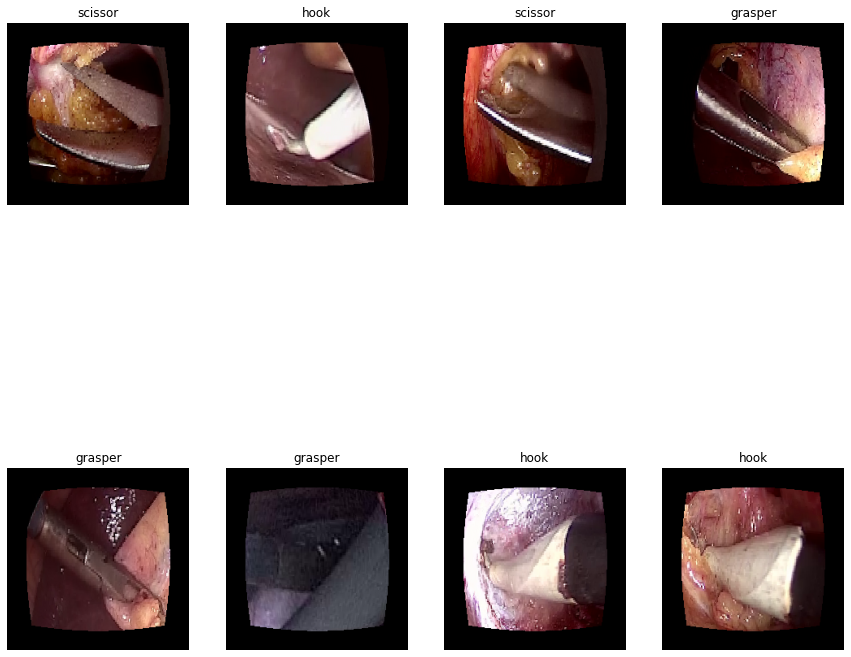

In [14]:
fig, axes = plt.subplots(2,4, figsize=(15, 15))               
random_batch =  random.randint(0, len(train_set)-1)
random_images, random_labels = train_set[random_batch]

for image_number, axs in enumerate(axes[0]):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])
# the same, but for the test set
random_batch =  random.randint(0, len(test_set)-1)
random_images, random_labels = test_set[random_batch]

for image_number, axs in enumerate(axes[1]):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])


In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3


base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUMBER_CLASSES, activation='softmax')(x)

modelVR = Model(inputs=base_model.input, outputs=predictions)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005) 

checkpoint_filepath = '/content/sample_data/vr'
modelVR_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc_3',
    mode='max',
    save_best_only=True
  )

modelVR.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(), 
                                                             tf.keras.metrics.Precision(), 
                                                             tf.keras.metrics.Recall()]
)

history = modelVR.fit(train_set, validation_data=validation_set, epochs=10,
                    callbacks=[modelVR_checkpoint_callback])

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.5407 - auc_1: 0.9537 - precision_1: 0.8642 - recall_1: 0.7742

75/75 [==============================] - 35s 381ms/step - loss: 0.5407 - auc_1: 0.9537 - precision_1: 0.8642 - recall_1: 0.7742 - val_loss: 1.5190 - val_auc_1: 0.9003 - val_precision_1: 0.7602 - val_recall_1: 0.7450
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.2502 - auc_1: 0.9874 - precision_1: 0.9355 - recall_1: 0.9058

75/75 [==============================] - 27s 355ms/step - loss: 0.2502 - auc_1: 0.9874 - precision_1: 0.9355 - recall_1: 0.9058 - val_loss: 0.2487 - val_auc_1: 0.9908 - val_precision_1: 0.9282 - val_recall_1: 0.9050
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.1525 - auc_1: 0.9943 - precision_1: 0.9619 - recall_1: 0.9467

75/75 [==============================] - 27s 357ms/step - loss: 0.1525 - auc_1: 0.9943 - precision_1: 0.9619 - recall_1: 0.9467 - val_loss: 3.4021 - val_auc_1: 0.8604 - val_precision_1: 0.7222 - val_recall_1: 0.7150
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.2820 - auc_1: 0.9830 - precision_1: 0.9354 - recall_1: 0.9050

75/75 [==============================] - 29s 383ms/step - loss: 0.2820 - auc_1: 0.9830 - precision_1: 0.9354 - recall_1: 0.9050 - val_loss: 0.4929 - val_auc_1: 0.9660 - val_precision_1: 0.8711 - val_recall_1: 0.8450
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: 0.1546 - auc_1: 0.9948 - precision_1: 0.9594 - recall_1: 0.9450

75/75 [==============================] - 28s 367ms/step - loss: 0.1546 - auc_1: 0.9948 - precision_1: 0.9594 - recall_1: 0.9450 - val_loss: 0.8274 - val_auc_1: 0.9531 - val_precision_1: 0.8889 - val_recall_1: 0.8800
Epoch 6/10
75/75 [==============================] - ETA: 0s - loss: 0.1195 - auc_1: 0.9968 - precision_1: 0.9630 - recall_1: 0.9542

75/75 [==============================] - 27s 360ms/step - loss: 0.1195 - auc_1: 0.9968 - precision_1: 0.9630 - recall_1: 0.9542 - val_loss: 0.3565 - val_auc_1: 0.9812 - val_precision_1: 0.9400 - val_recall_1: 0.9400
Epoch 7/10
75/75 [==============================] - ETA: 0s - loss: 0.0823 - auc_1: 0.9973 - precision_1: 0.9832 - recall_1: 0.9750

75/75 [==============================] - 27s 359ms/step - loss: 0.0823 - auc_1: 0.9973 - precision_1: 0.9832 - recall_1: 0.9750 - val_loss: 0.7856 - val_auc_1: 0.9570 - val_precision_1: 0.8434 - val_recall_1: 0.8350
Epoch 8/10
75/75 [==============================] - ETA: 0s - loss: 0.1163 - auc_1: 0.9957 - precision_1: 0.9681 - recall_1: 0.9625

75/75 [==============================] - 28s 373ms/step - loss: 0.1163 - auc_1: 0.9957 - precision_1: 0.9681 - recall_1: 0.9625 - val_loss: 0.3575 - val_auc_1: 0.9807 - val_precision_1: 0.9146 - val_recall_1: 0.9100
Epoch 9/10
75/75 [==============================] - ETA: 0s - loss: 0.0498 - auc_1: 0.9996 - precision_1: 0.9849 - recall_1: 0.9817

75/75 [==============================] - 27s 358ms/step - loss: 0.0498 - auc_1: 0.9996 - precision_1: 0.9849 - recall_1: 0.9817 - val_loss: 1.4192 - val_auc_1: 0.8841 - val_precision_1: 0.7436 - val_recall_1: 0.7250
Epoch 10/10
75/75 [==============================] - ETA: 0s - loss: 0.1273 - auc_1: 0.9953 - precision_1: 0.9623 - recall_1: 0.9575

75/75 [==============================] - 27s 358ms/step - loss: 0.1273 - auc_1: 0.9953 - precision_1: 0.9623 - recall_1: 0.9575 - val_loss: 0.4693 - val_auc_1: 0.9806 - val_precision_1: 0.9141 - val_recall_1: 0.9050


In [16]:
l, a, p, r = modelVR.evaluate(test_set)
print(f"Resulting model has {l} loss, {a} auc score and {p}/{r}\
 precision/recall on the test set")

38/38 [==============================] - 11s 281ms/step - loss: 0.3797 - auc_1: 0.9783 - precision_1: 0.9102 - recall_1: 0.8965
Resulting model has 0.37970349192619324 loss, 0.978294312953949 auc score and 0.9101694822311401/0.8964941501617432 precision/recall on the test set


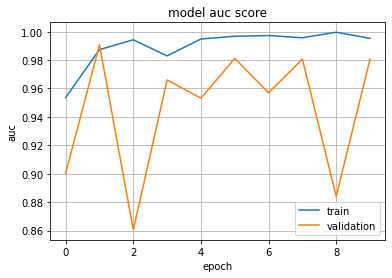

In [20]:
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model auc score')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

Auc score has decreased, but the model still works fine.

### This part is needed to create the onnx model

In [22]:
modelVR.save_weights('./kekpoint/vrCheckpoint')


In [23]:
! python -m pip install tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 29.1 MB/s 
     |████████████████████████████████| 13.1 MB 18.7 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [26]:
! python -m pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import tf2onnx
import onnx
input_signature = [tf.TensorSpec([None, None, None, 3], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(modelVR, input_signature, opset=13)
onnx.save(onnx_model, "./model.onnx")

In [31]:
! python -m pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 30.8 MB/s 
     |████████████████████████████████| 46 kB 2.4 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 


In [55]:
import onnxruntime as ort
import numpy as np

# Change shapes and types to match model
input1 = np.zeros((1, 100, 100, 3), np.float32)

# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# Following code assumes NVIDIA GPU is available, you can specify other execution providers or don't include providers parameter
# to use default CPU provider.
sess = ort.InferenceSession("./model.onnx", providers=["CUDAExecutionProvider"])

# Set first argument of sess.run to None to use all model outputs in default order
# Input/output names are printed by the CLI and can be set with --rename-inputs and --rename-outputs
# If using the python API, names are determined from function arg names or TensorSpec names.
results_ort = sess.run(["dense_3"], {"x": input1})

import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)

results_tf = modelVR(input1)

for ort_res, tf_res in zip(results_ort, results_tf):
    np.testing.assert_allclose(ort_res[0], tf_res, rtol=1e-5, atol=1e-5)


/usr/local/lib/python3.7/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))
